Using TensorFlow backend.


(50000, 28, 28) (50000,)


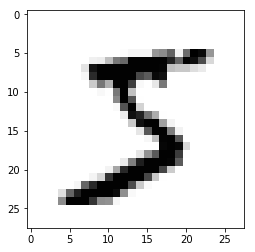

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

In [20]:
# Get size for training, development (validation), test sets
print(X_train.shape)
m = X_train.shape[0]  # num of training images
n = X_train.shape[1] * X_train.shape[1]  # num of features in 1 image
c = 10 # output has 10 classes
print('m =', m, 'n = ', n)

(50000, 28, 28)
m = 50000 n =  784


In [21]:
# Flatten traingin and test images
def flattenRawData(rawData):
    return rawData.reshape((rawData.shape[0], -1))

X_train_flat = flattenRawData(X_train)
X_val_flat = flattenRawData(X_val)
X_test_flat =flattenRawData(X_test)

# The grayscale images do not require normalize

In [22]:
# Testing bolck 
print('X_train_flat.shape = ', X_train_flat.shape)
print('X_val_flat.shape = ', X_val_flat.shape)
print('X_test_flat.shape = ', X_test_flat.shape)

X_train_flat.shape =  (50000, 784)
X_val_flat.shape =  (10000, 784)
X_test_flat.shape =  (10000, 784)


In [23]:
# Using one hot encoding to generate a m(# of samples) x c(# of classes) matrix
# eg: when c = 3, [[0],[1],[2]] becomes [[1,0,0],[0,1,0],[0,0,1]]
def oneHotMatrix(y, C):
    C = tf.constant(C)
    oneHotMat = tf.one_hot(y, C, axis=1)
    sess = tf.Session()
    one_hot = sess.run(oneHotMat)
    sess.close()
    return np.squeeze(one_hot)

In [24]:
# Testing bolck 
y_train_hot = oneHotMatrix(y_train, c)
y_val_hot = oneHotMatrix(y_val, c)
y_test_hot = oneHotMatrix(y_test, c)
print('y_train_hot.shape = ', y_train_hot.shape)
print('y_train[5] = ', y_train[5])
print('y_train_hot[5,:] = ', str(y_train_hot[5,:]))

y_train_hot.shape =  (50000, 10)
y_train[5] =  2
y_train_hot[5,:] =  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [25]:
# create Tensors: initializing parameters and creating placeholders
def createPlaceHolders(n, c):
    X = tf.placeholder(tf.float32, shape=(None, n))
    Y = tf.placeholder(tf.float32, shape=(None, c))
    return X, Y

In [26]:
# Testing bolck 
X, Y = createPlaceHolders(n, c)
print ('X = ' + str(X))
print ('Y = ' + str(Y))

X = Tensor("Placeholder_4:0", shape=(?, 784), dtype=float32)
Y = Tensor("Placeholder_5:0", shape=(?, 10), dtype=float32)


In [27]:
# Initialize 2 hidden layers
def initParameters(n, n_h1, n_h2, c):
    tf.set_random_seed(1)
    W1 = tf.get_variable('W1', [n, n_h1], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [1, n_h1], initializer= tf.zeros_initializer())
    W2 = tf.get_variable('W2', [n_h1, n_h2], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [1, n_h2], initializer= tf.zeros_initializer())
    W3 = tf.get_variable('W3', [n_h2, c], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [1, c], initializer= tf.zeros_initializer())
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

In [30]:
# Testing bolck 
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initParameters(n, 64, 32, c)
    print('W1 = ' + str(parameters['W1']))
    print('b1 = ' + str(parameters['b1']))
    print('W2 = ' + str(parameters['W2']))
    print('b2 = ' + str(parameters['b2']))
    print('W3 = ' + str(parameters['W3']))
    print('b3 = ' + str(parameters['b3']))

W1 = <tf.Variable 'W1:0' shape=(784, 64) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(1, 64) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(64, 32) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(1, 32) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(32, 10) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(1, 10) dtype=float32_ref>


In [39]:
# Activation function can be sigmoid or ReLu
def forwardProp(X, parameters, method = 'relu'):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(X, W1), b1)
    if method == 'relu':
        A1 = tf.nn.relu(Z1)
    else:
        A1 = tf.nn.sigmoid(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)
    if method == 'relu':
        A2 = tf.nn.relu(Z2)
    else:
        A2 = tf.nn.sigmoid(Z2)
    Z3 = tf.add(tf.matmul(A2, W3), b3)
    return Z3

In [40]:
def computeCost(Z, Y):
#     print('Z.shape=', Z.shape)
#     print('Y.shape=', Y.shape)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z, labels=Y))
    return cost

In [41]:
# Testing bolck 
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = createPlaceHolders(n, c)
    parameters = initParameters(n, 64, 32, c)
    Z = forwardProp(X, parameters)
    cost = computeCost(Z, Y)
    print('cost = ', cost)

cost =  Tensor("Mean:0", shape=(), dtype=float32)


In [42]:
# Generate mini batches
def genMiniBatch(X, Y, mini_batch_size = 64, seed = 0):
    # TODO: 1 shuffle, 2 partition, 3 handle the leftover
    m = X.shape[0]    # # of training samples
    mini_batches = []
    np.random.seed(seed)    # reset RNG
    
    # shuffle
    
    # partition
    
    # attach the leftover at the ned
    
    return mini_batches

In [44]:
def model(X_train, Y_train, X_dev, Y_dev, n_hidden1=64, n_hidden2=32, learning_rate=0.01, decay_rate=0.9, num_epochs=500):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    (m, n) = X_train.shape
    c = Y_train.shape[1]
    print('m = ', m, 'n = ', n, 'c = ', c)
    costs = []
    
    # initialization
    X, Y = createPlaceHolders(n, c)
    parameters = initParameters(n, n_hidden1, n_hidden2, c)
    
    # forward propagation
    Z = forwardProp(X, parameters)
    # update cost
    cost = computeCost(Z, Y)
    
    # ues learning rate exponential decay
    global_step = tf.Variable(0, trainable=False)
    adapt_learning_rate = tf.train.exponential_decay(learning_rate, global_step, 10, decay_rate, staircase=True)
    
    # back propagation
    optimizer = tf.train.AdamOptimizer(adapt_learning_rate).minimize(cost, global_step=global_step)    
        
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            _ , current_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
            
            # print accuracy for dev set
            if epoch % 20 == 0:
                correct_prediction = tf.equal(tf.argmax(Z, axis=1), tf.argmax(Y, axis=1))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                p = accuracy.eval({X: X_dev, Y: Y_dev})
                print ("Cost after epoch %i: %f, Learning_rate = %f, Dev accuracy: %f" % (epoch, current_cost, adapt_learning_rate.eval(), p))
            costs.append(current_cost)
        
        # plot cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        correct_prediction = tf.equal(tf.argmax(Z, axis=1), tf.argmax(Y, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_dev, Y: Y_dev}))
        
        parameters = sess.run(parameters)
        return parameters

m =  50000 n =  784 c =  10
Cost after epoch 0: 2.377753, Learning_rate = 0.010000, Dev accuracy: 0.299000
Cost after epoch 20: 0.326818, Learning_rate = 0.008100, Dev accuracy: 0.917000
Cost after epoch 40: 0.217214, Learning_rate = 0.006561, Dev accuracy: 0.940500
Cost after epoch 60: 0.168016, Learning_rate = 0.005314, Dev accuracy: 0.950800
Cost after epoch 80: 0.139087, Learning_rate = 0.004305, Dev accuracy: 0.954200
Cost after epoch 100: 0.120038, Learning_rate = 0.003487, Dev accuracy: 0.958100
Cost after epoch 120: 0.106383, Learning_rate = 0.002824, Dev accuracy: 0.961100
Cost after epoch 140: 0.096033, Learning_rate = 0.002288, Dev accuracy: 0.963600
Cost after epoch 160: 0.088071, Learning_rate = 0.001853, Dev accuracy: 0.964800
Cost after epoch 180: 0.081980, Learning_rate = 0.001501, Dev accuracy: 0.965600


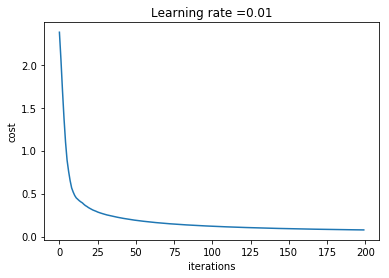

Train Accuracy: 0.97802
Test Accuracy: 0.9663


In [48]:
tf.reset_default_graph()

parameters = model(X_train_flat, y_train_hot, X_val_flat, y_val_hot, n_hidden1=64, n_hidden2=32, num_epochs=200)

In [49]:
XT, YT = createPlaceHolders(n, c)
Z = forwardProp(XT, parameters)
correct_prediction = tf.cast(tf.equal(tf.argmax(Z, axis=1), tf.argmax(YT, axis=1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

with tf.Session() as sess:
    acc = sess.run(accuracy, feed_dict = {XT: X_train_flat, YT: y_train_hot})
    print ("Train Accuracy:", acc)
    acc = sess.run(accuracy, feed_dict = {XT: X_val_flat, YT: y_val_hot})
    print ("Dev Accuracy:", acc)
    acc = sess.run(accuracy, feed_dict = {XT: X_test_flat, YT: y_test_hot})
    print ("Test Accuracy:", acc)

Train Accuracy: 0.97802
Dev Accuracy: 0.9663
Test Accuracy: 0.9638
